# Propensity Model

## Preliminary Code (Importing Libraries, Loading the Dataset)

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE


In [2]:
march_2024 = pd.read_parquet('../Data/Product Flags/cust_info_prod_202403_processed.parquet')
cust_info = pd.read_parquet('../Data/Other Data/CUSTOMER INFO.parquet')
merged_df = pd.merge(march_2024, cust_info, on='CUST_NUM', how='inner')
pd.set_option('display.max_columns', None)
merged_df = merged_df[merged_df['SUBSEGMENT'] == 'Middle Tier']

merged_df

,CUST_NUM,IB,BUILDUP_F,CASH_MANAGEMENT,CORPORATE_LOANS,RETAIL_LOAN,TRADE_SERVICES,INVESTMENT_FUNDS,SECURITIES,INSURANCE,CORPORATE_FINANCE,FOREX,REMITTANCE,CORPORATE_CARDS,BB,DEPOSITS,RETAIL_PRODUCTS,INVESTMENTS_AND_SECURITIES,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,IDV_OR_ORG,SUBSEGMENT,GENDER,MARITAL_STATUS
19,7024.550092,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,TARLAC,REGION III (CENTRAL LUZON),LOW,22.0,1.136986,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Middle Tier,FEMALE,SINGLE
26,8130.613999,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,TARLAC,REGION III (CENTRAL LUZON),NO_DATA,23.0,1.539726,N,DIGITAL,ALLOWANCE,INDIVIDUAL,Middle Tier,FEMALE,SINGLE
36,9468.012674,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,TARLAC,REGION III (CENTRAL LUZON),NO_DATA,18.0,1.991781,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Middle Tier,FEMALE,SINGLE
77,594.291174,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,LOW,22.0,6.441096,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Middle Tier,MALE,SINGLE
84,677.304953,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,LOW,20.0,8.276712,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Middle Tier,MALE,SINGLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298158,13755.952312,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,SULTAN KUDARAT,REGION XII (SOCCSKSARGEN),HIGH,78.0,5.150685,N,TRADITIONAL,PENSION,INDIVIDUAL,Middle Tier,MALE,SINGLE
298159,13799.244907,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,SULTAN KUDARAT,REGION XII (SOCCSKSARGEN),MID,51.0,15.580822,N,TRADITIONAL,PENSION,INDIVIDUAL,Middle Tier,MALE,SINGLE
298161,13862.984599,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,SULTAN KUDARAT,REGION XII (SOCCSKSARGEN),LOW,28.0,8.506849,N,TRADITIONAL,ALLOWANCE,INDIVIDUAL,Middle Tier,OTHERS,SINGLE
298165,14002.523487,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,SULTAN KUDARAT,REGION XII (SOCCSKSARGEN),NO_DATA,35.0,2.298630,N,TRADITIONAL,SALARY,INDIVIDUAL,Middle Tier,FEMALE,MARRIED


## Data Cleaning

In [3]:
columns_to_keep = [
    'CUST_NUM', 'CORPORATE_LOANS', 'RETAIL_LOAN', 'TRADE_SERVICES', 'INVESTMENT_FUNDS',
    'SECURITIES', 'INSURANCE', 'CORPORATE_FINANCE', 'FOREX', 'REMITTANCE',
    'CORPORATE_CARDS', 'DEPOSITS', 'RETAIL_PRODUCTS', 'INVESTMENTS_AND_SECURITIES',
    'AGE', 'GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE',
    'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'DIGITAL_FLAG', 'TENURE', 'SUBSEGMENT'
]

merged_df = merged_df[columns_to_keep]
merged_df['GENDER'] = merged_df['GENDER'].replace('MLE', 'MALE')


/var/folders/jv/0sr2mpzx5klfxvmfj4s39_vm0000gn/T/ipykernel_20817/3811362480.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['GENDER'] = merged_df['GENDER'].replace('MLE', 'MALE')


## Exploratory Data Analysis

In [4]:
def check_class_imbalance(df, target_variable):
    class_counts = df[target_variable].value_counts()
    print(f"Class distribution for {target_variable}:\n{class_counts}")

    # Visualize the class distribution
    plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
    plt.title(f"Class Distribution for {target_variable}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks([0, 1], ['Not Purchased', 'Purchased'])
    plt.show()
    
def analyze_categorical_features(df, categorical_columns):
    for column in categorical_columns:
        print(f"\nValue counts for {column}:\n{df[column].value_counts()}")
        df[column].value_counts().plot(kind='bar', title=f"Distribution of {column}")
        plt.show()

def analyze_numerical_features(df, numerical_columns):
    print("Summary statistics for numerical features:")
    print(df[numerical_columns].describe())

    for column in numerical_columns:
        plt.hist(df[column].dropna(), bins=20, edgecolor='black')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print("Columns with missing values:\n", missing_cols)
    else:
        print("No missing values found.")


Class distribution for CORPORATE_LOANS:
0    65117
1       44
Name: CORPORATE_LOANS, dtype: int64


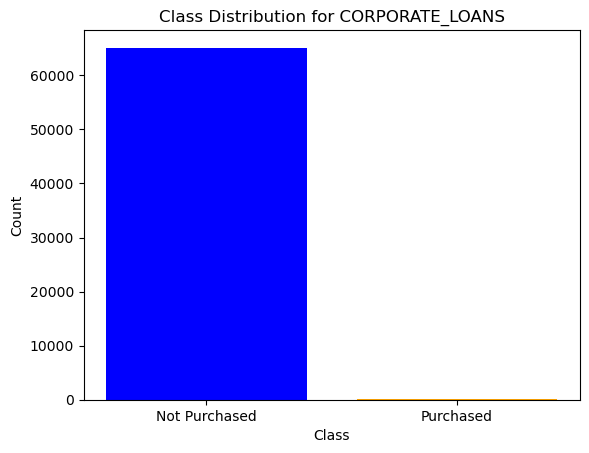

Class distribution for RETAIL_LOAN:
0    65132
1       29
Name: RETAIL_LOAN, dtype: int64


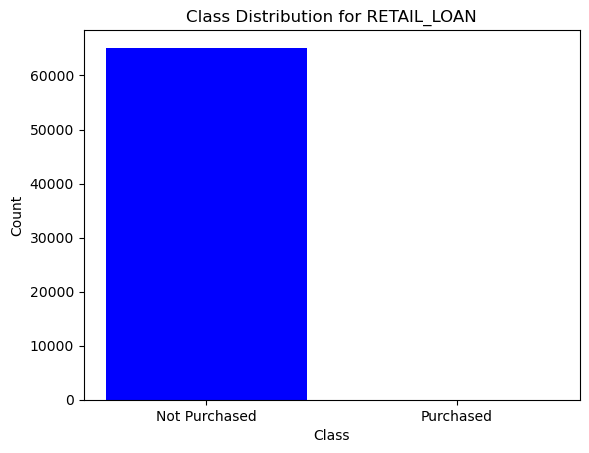

Class distribution for TRADE_SERVICES:
0    65160
1        1
Name: TRADE_SERVICES, dtype: int64


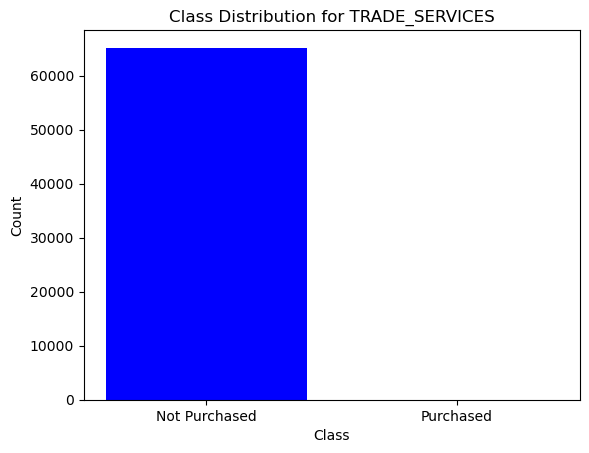

Class distribution for INVESTMENT_FUNDS:
0    65161
Name: INVESTMENT_FUNDS, dtype: int64


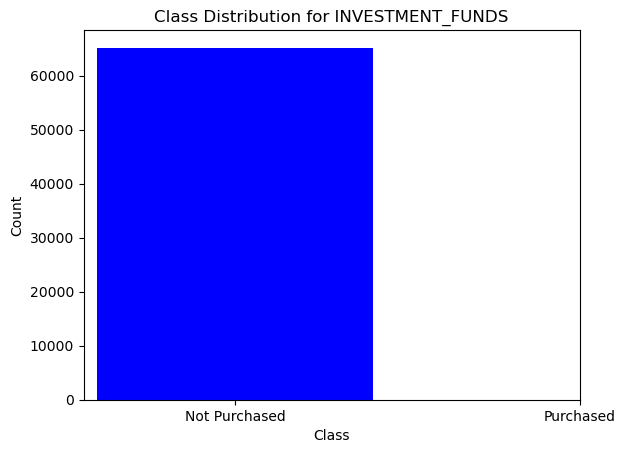

Class distribution for SECURITIES:
0    65161
Name: SECURITIES, dtype: int64


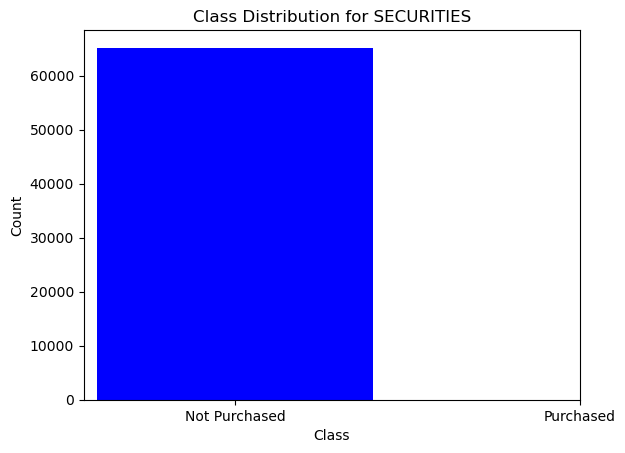

Class distribution for INSURANCE:
0    58874
1     6287
Name: INSURANCE, dtype: int64


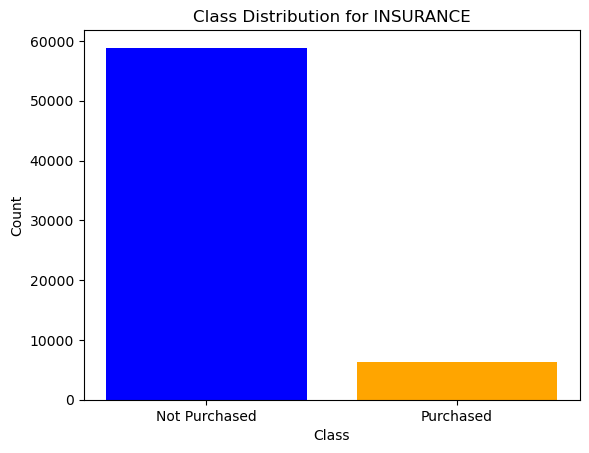

Class distribution for CORPORATE_FINANCE:
0    65161
Name: CORPORATE_FINANCE, dtype: int64


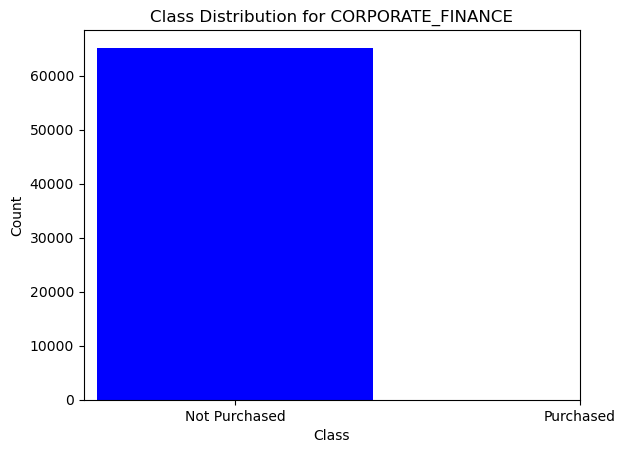

Class distribution for FOREX:
0    64675
1      486
Name: FOREX, dtype: int64


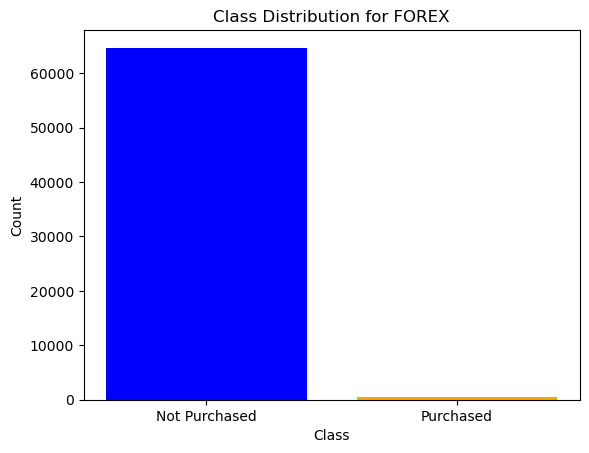

Class distribution for REMITTANCE:
0    65161
Name: REMITTANCE, dtype: int64


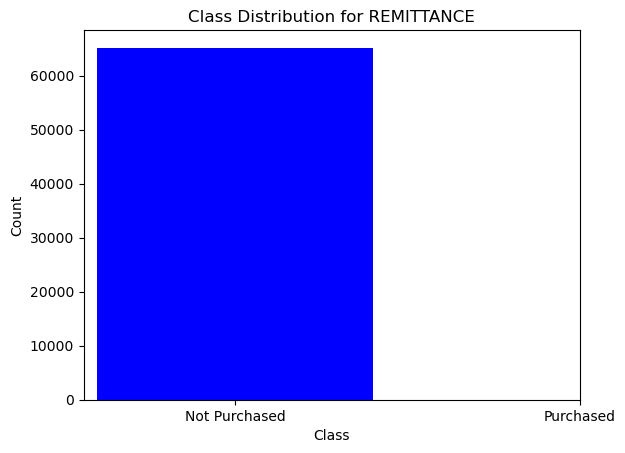

Class distribution for CORPORATE_CARDS:
0    65158
1        3
Name: CORPORATE_CARDS, dtype: int64


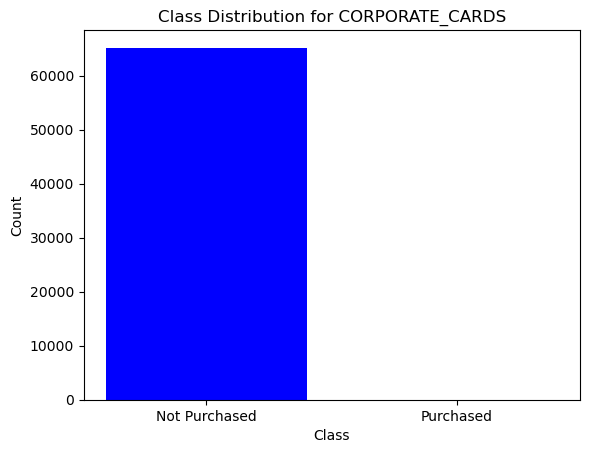

Class distribution for DEPOSITS:
1    65059
0      102
Name: DEPOSITS, dtype: int64


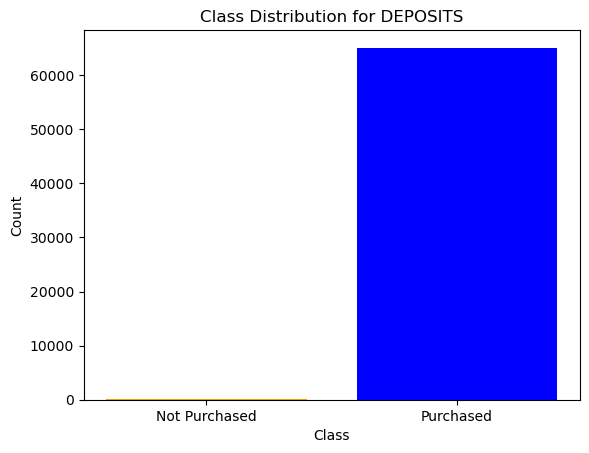

Class distribution for RETAIL_PRODUCTS:
0    47689
1    17472
Name: RETAIL_PRODUCTS, dtype: int64


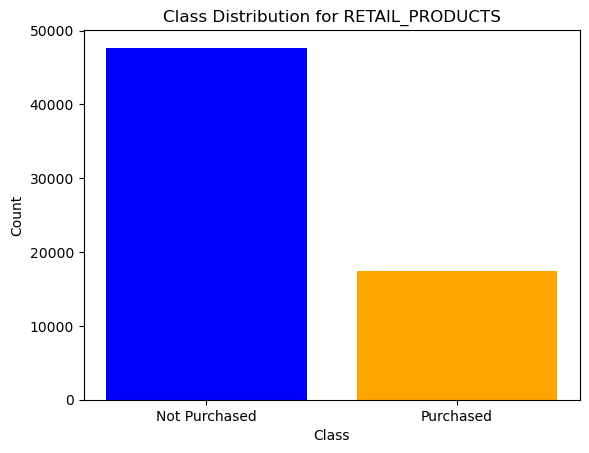

Class distribution for INVESTMENTS_AND_SECURITIES:
0    64184
1      977
Name: INVESTMENTS_AND_SECURITIES, dtype: int64


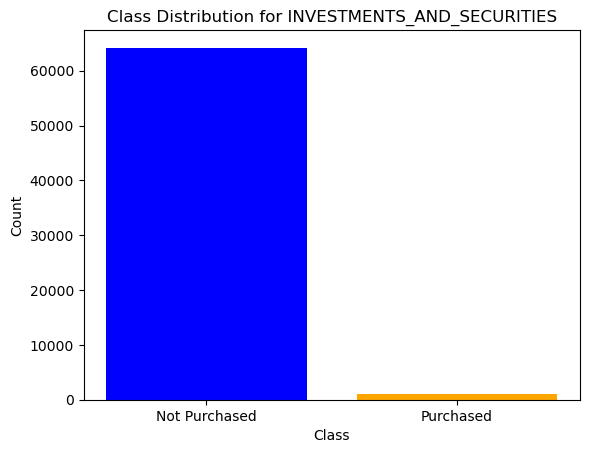

In [5]:
product_categories = ['CORPORATE_LOANS', 'RETAIL_LOAN', 'TRADE_SERVICES', 'INVESTMENT_FUNDS', 
                      'SECURITIES', 'INSURANCE', 'CORPORATE_FINANCE', 'FOREX', 
                      'REMITTANCE', 'CORPORATE_CARDS', 'DEPOSITS', 
                      'RETAIL_PRODUCTS', 'INVESTMENTS_AND_SECURITIES']

for target in product_categories:
    check_class_imbalance(merged_df, target)


Value counts for GENDER:
FEMALE    37563
MALE      26247
OTHERS     1351
Name: GENDER, dtype: int64


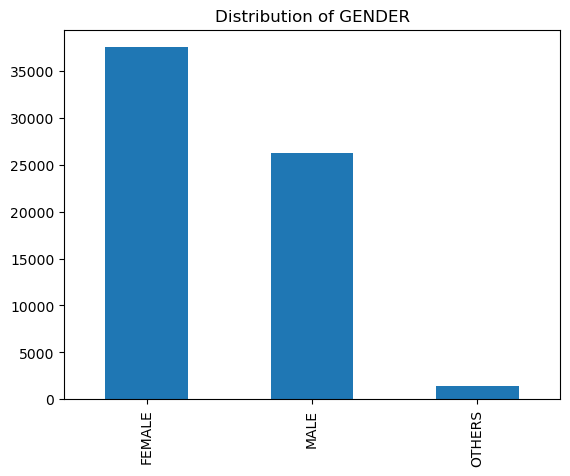


Value counts for MARITAL_STATUS:
SINGLE       36000
MARRIED      24655
WIDOWED       2015
DIVORCED      1223
SEPARATED      646
OTHERS         622
Name: MARITAL_STATUS, dtype: int64


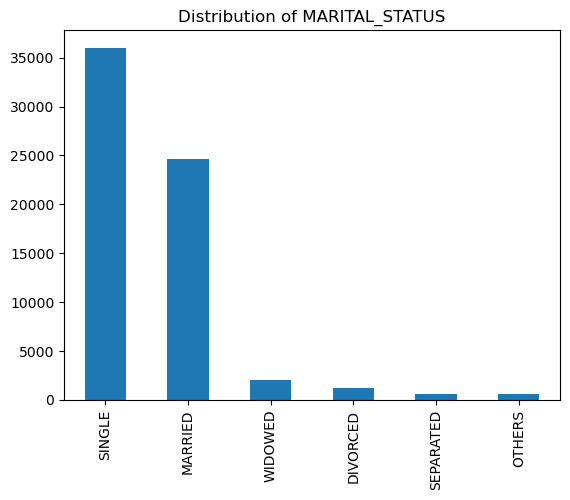


Value counts for EDUCATION:
MID        43819
LOW         9734
NO_DATA     9332
HIGH        2276
Name: EDUCATION, dtype: int64


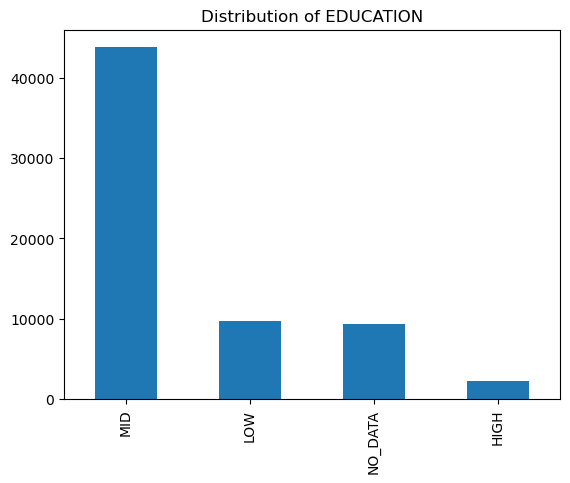


Value counts for INCOME_SOURCE:
SALARY                                     43190
ALLOWANCE                                   6400
BUSINESS                                    5564
PENSION                                     3844
REMITTANCE                                  3671
OTHER_SOURCES_NOT_SPECIFIED                  831
NO_DATA                                      660
COMMISSION                                   629
INTEREST_SAVINGS_PLACEMENTS_INVESTMENTS      260
ECONOMICALLY_INACTIVE                         99
DONATION                                      13
Name: INCOME_SOURCE, dtype: int64


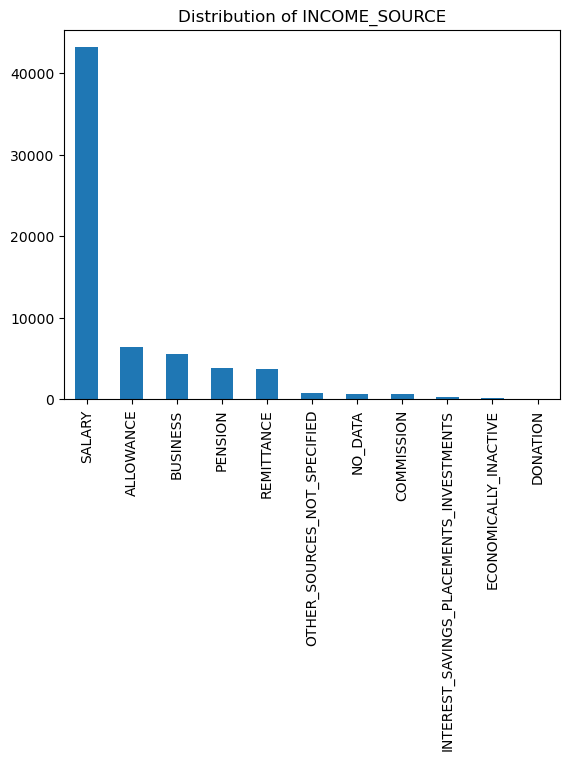


Value counts for BUSINESS_OWNER:
N    59881
Y     5280
Name: BUSINESS_OWNER, dtype: int64


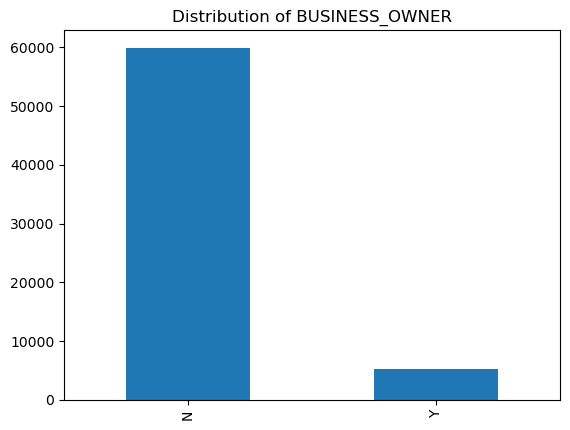


Value counts for PROVINCE:
NATIONAL CAPITAL REGION           28962
CAVITE                             3602
CEBU                               3209
LAGUNA                             3153
BULACAN                            2128
PAMPANGA                           1950
RIZAL                              1900
BATANGAS                           1804
ILOILO                             1635
DAVAO DEL SUR                      1435
NEGROS OCCIDENTAL                  1245
PANGASINAN                         1071
MISAMIS ORIENTAL                    934
BENGUET                             915
NUEVA ECIJA                         598
ZAMBOANGA DEL SUR                   585
ZAMBALES                            575
BOHOL                               549
LEYTE                               519
SOUTH COTABATO                      517
QUEZON                              508
TARLAC                              448
ISABELA                             441
CAMARINES SUR                       440
LA UNION    

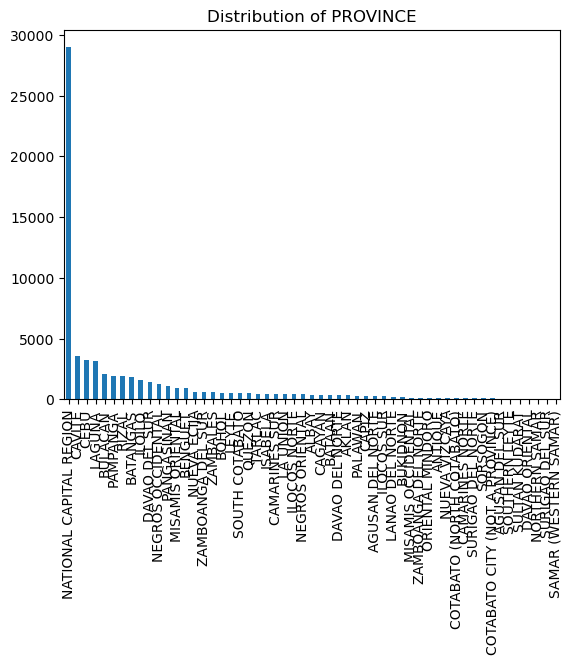


Value counts for REGION:
NATIONAL CAPITAL REGION                   28962
REGION IV-A (CALABARZON)                  10967
REGION III (CENTRAL LUZON)                 6057
REGION VII (CENTRAL VISAYAS)               4176
REGION VI (WESTERN VISAYAS)                3609
REGION I (ILOCOS REGION)                   2176
REGION XI (DAVAO REGION)                   1797
REGION X (NORTHERN MINDANAO)               1493
REGION V (BICOL REGION)                    1052
REGION II (CAGAYAN VALLEY)                  951
CORDILLERA ADMINISTRATIVE REGION (CAR)      915
REGION XII (SOCCSKSARGEN)                   796
REGION IX (ZAMBOANGA PENINSULA)             728
REGION VIII (EASTERN VISAYAS)               629
REGION XIII (CARAGA)                        444
MIMAROPA REGION                             409
Name: REGION, dtype: int64


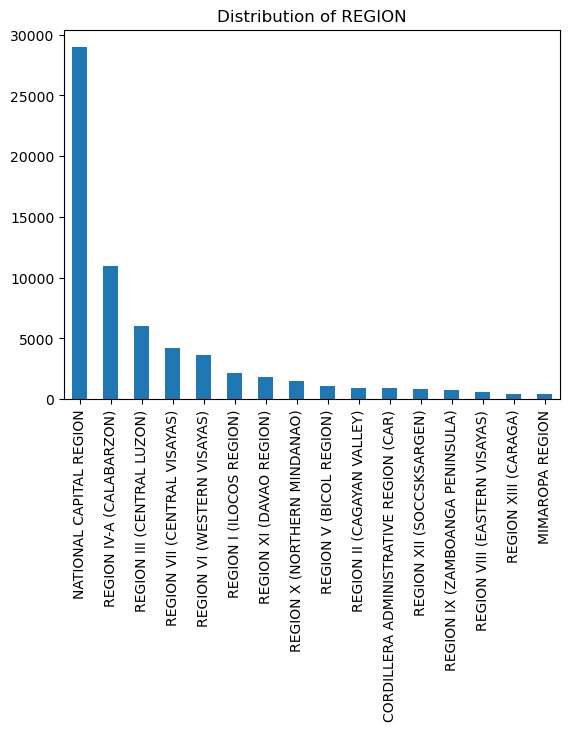


Value counts for SUBSEGMENT:
Middle Tier    65161
Name: SUBSEGMENT, dtype: int64


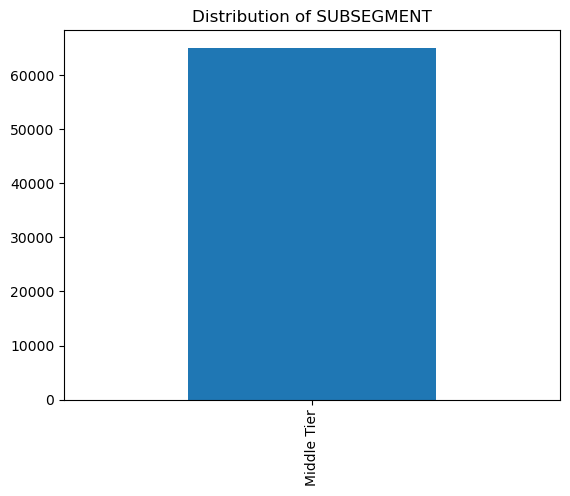

In [6]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                       'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT']
analyze_categorical_features(merged_df, categorical_columns)

Summary statistics for numerical features:
                AGE        TENURE
count  65118.000000  65161.000000
mean      43.441798      9.811399
std       14.428230      6.305032
min        2.000000      0.926027
25%       32.000000      5.019178
50%       41.000000      8.756164
75%       52.000000     13.298630
max      134.000000     31.145205


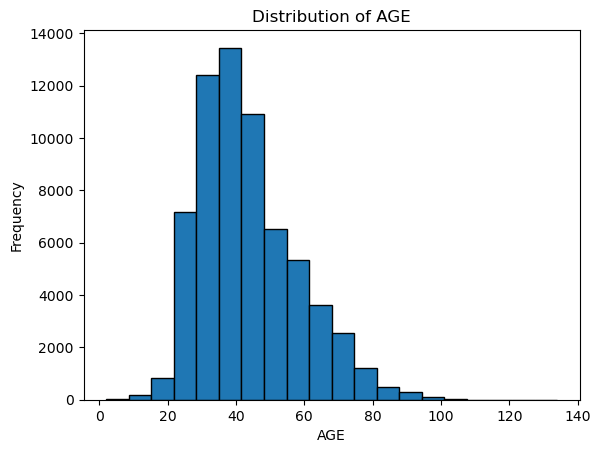

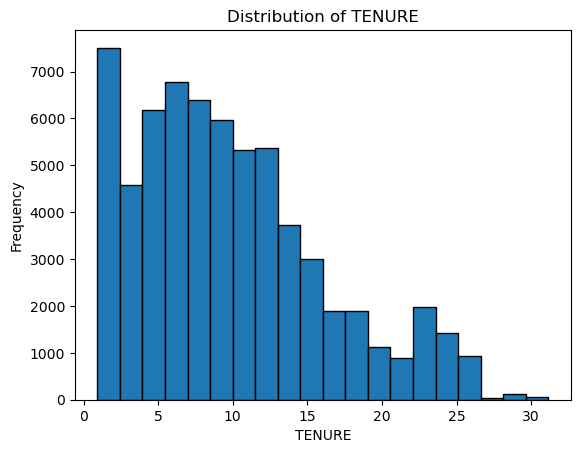

In [7]:
numerical_columns = ['AGE', 'TENURE']
analyze_numerical_features(merged_df, numerical_columns)

In [8]:
check_missing_values(merged_df)

Columns with missing values:
 AGE    43
dtype: int64


## Data Preprocessing

### Removing Null Values

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
merged_df['AGE'] = imputer.fit_transform(merged_df[['AGE']])

/var/folders/jv/0sr2mpzx5klfxvmfj4s39_vm0000gn/T/ipykernel_20817/926605328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['AGE'] = imputer.fit_transform(merged_df[['AGE']])


### Defining the Feature Matrix and Target Variable

In [10]:
target_product = 'INSURANCE'
X = merged_df.drop(columns=['CUST_NUM', target_product])  
y = merged_df[target_product] 

### One-Hot Encoding

In [11]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                       'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT', 'DIGITAL_FLAG']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Smote to Handle Class Imbalance

In [13]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE:
1    41211
0    41211
Name: INSURANCE, dtype: int64


## Model Training

In [14]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Model Validation

In [15]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(classification_report_output)

ROC-AUC Score: 0.6059768762507723
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     17663
           1       0.15      0.25      0.19      1886

    accuracy                           0.79     19549
   macro avg       0.53      0.55      0.53     19549
weighted avg       0.84      0.79      0.81     19549



In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

def train_xgboost_propensity_model(dataset, target_product, test_size=0.3, random_state=42, use_smote=True):
    X = dataset.drop(columns=['CUST_NUM', target_product])
    y = dataset[target_product]

    categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                           'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT', 'DIGITAL_FLAG']
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    # Check class distribution
    class_counts = y.value_counts()
    if len(class_counts) < 2 or class_counts.min() < 2:
        print(f"Skipping training for {target_product} as it contains a class with fewer than 2 instances.")
        return

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            random_state=random_state, stratify=y)
    except ValueError as e:
        print(f"Falling back to non-stratified split for {target_product}: {e}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if use_smote:
        smote = SMOTE(random_state=random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print("Class distribution after SMOTE:")
        print(pd.Series(y_train_resampled).value_counts())
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    xgb_model = XGBClassifier(random_state=random_state, eval_metric='logloss')
    xgb_model.fit(X_train_resampled, y_train_resampled)

    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    classification_report_output = classification_report(y_test, y_pred)
    
    print(f"ROC-AUC Score for {target_product}: {roc_auc}")
    print(f"Classification Report for {target_product}:")
    print(classification_report_output)

    # Plot feature importance
    plt.figure(figsize=(15, 10))
    plot_importance(xgb_model, importance_type='weight', max_num_features=None)
    plt.title(f"Feature Importance for {target_product}")
    plt.show()


ROC-AUC Score for CORPORATE_LOANS: 0.8848555723555723
Classification Report for CORPORATE_LOANS:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19536
           1       0.00      0.00      0.00        13

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



<Figure size 1500x1000 with 0 Axes>

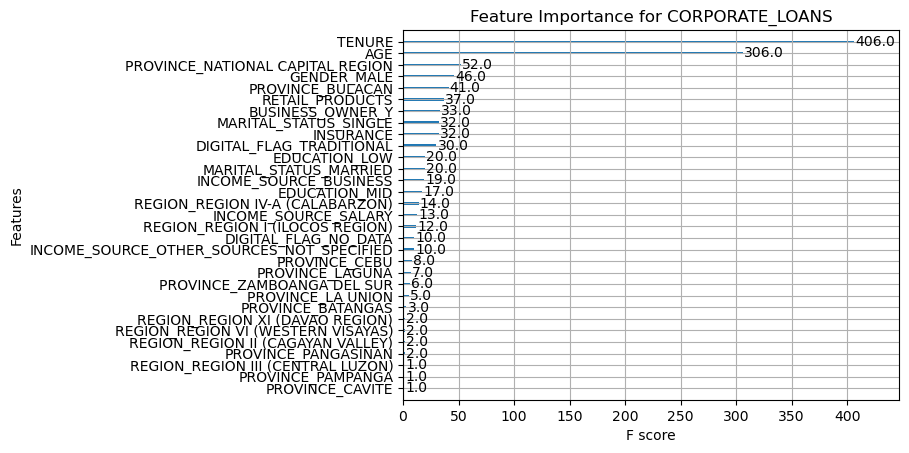

ROC-AUC Score for RETAIL_LOAN: 0.9323780279767997
Classification Report for RETAIL_LOAN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19540
           1       0.00      0.00      0.00         9

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



<Figure size 1500x1000 with 0 Axes>

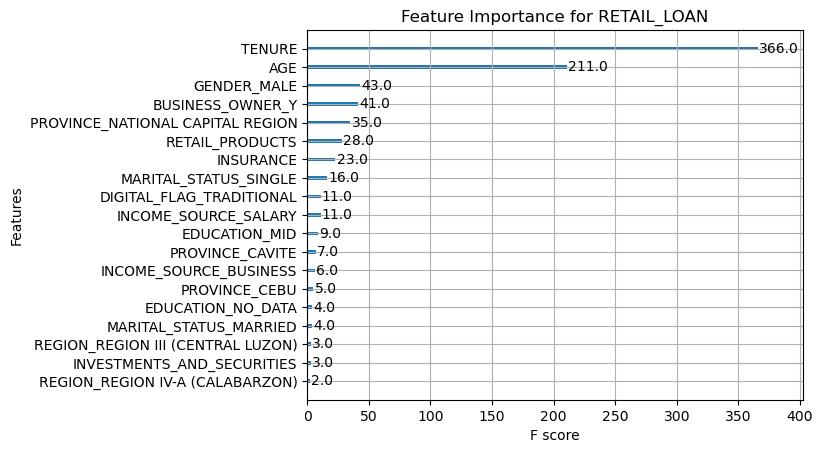

Skipping training for TRADE_SERVICES as it contains a class with fewer than 2 instances.
Skipping training for INVESTMENT_FUNDS as it contains a class with fewer than 2 instances.
Skipping training for SECURITIES as it contains a class with fewer than 2 instances.
ROC-AUC Score for INSURANCE: 0.6632211297300604
Classification Report for INSURANCE:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17663
           1       0.25      0.01      0.01      1886

    accuracy                           0.90     19549
   macro avg       0.57      0.50      0.48     19549
weighted avg       0.84      0.90      0.86     19549



<Figure size 1500x1000 with 0 Axes>

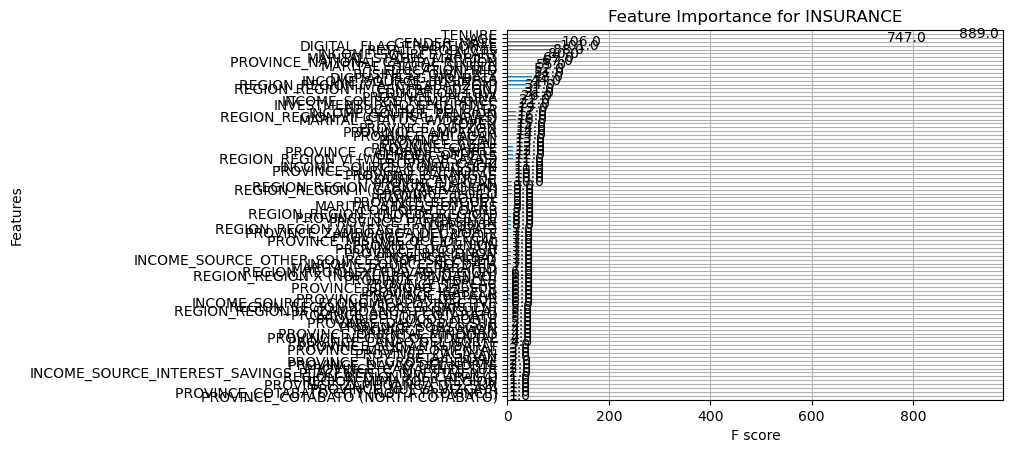

Skipping training for CORPORATE_FINANCE as it contains a class with fewer than 2 instances.
ROC-AUC Score for FOREX: 0.5840875828409531
Classification Report for FOREX:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19403
           1       0.00      0.00      0.00       146

    accuracy                           0.99     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       0.99      0.99      0.99     19549



<Figure size 1500x1000 with 0 Axes>

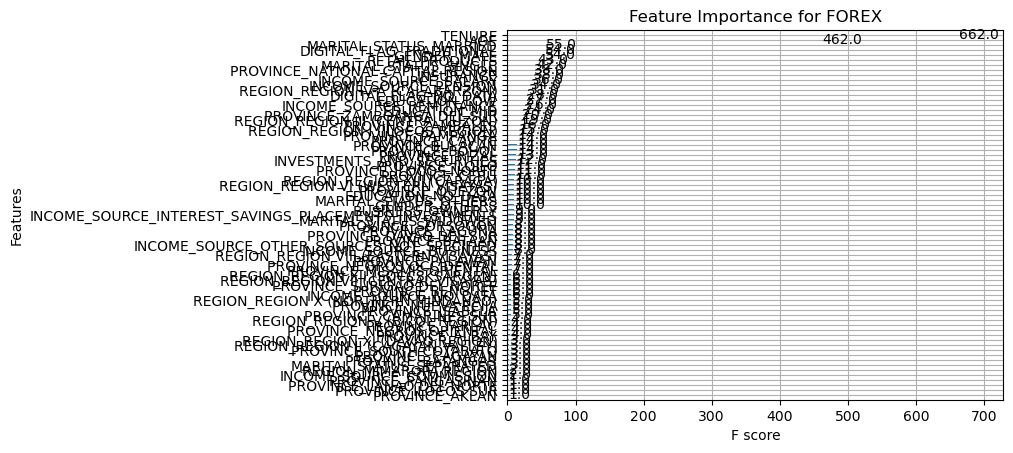

Skipping training for REMITTANCE as it contains a class with fewer than 2 instances.
ROC-AUC Score for CORPORATE_CARDS: 0.1937538367096378
Classification Report for CORPORATE_CARDS:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19548
           1       0.00      0.00      0.00         1

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1500x1000 with 0 Axes>

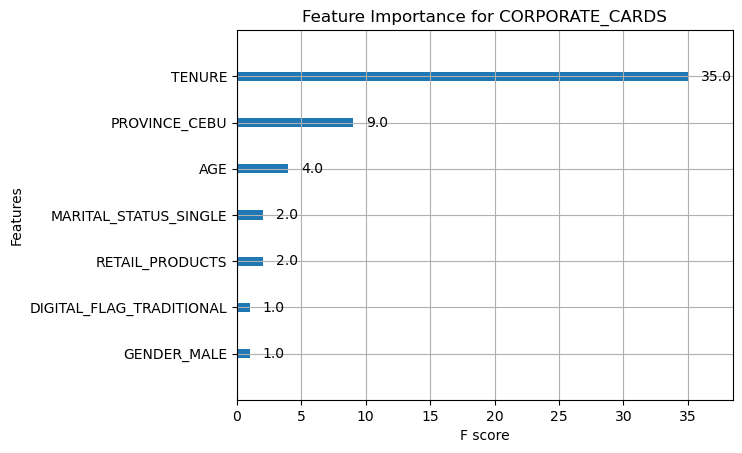

ROC-AUC Score for DEPOSITS: 0.7961079764254004
Classification Report for DEPOSITS:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       1.00      1.00      1.00     19518

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



<Figure size 1500x1000 with 0 Axes>

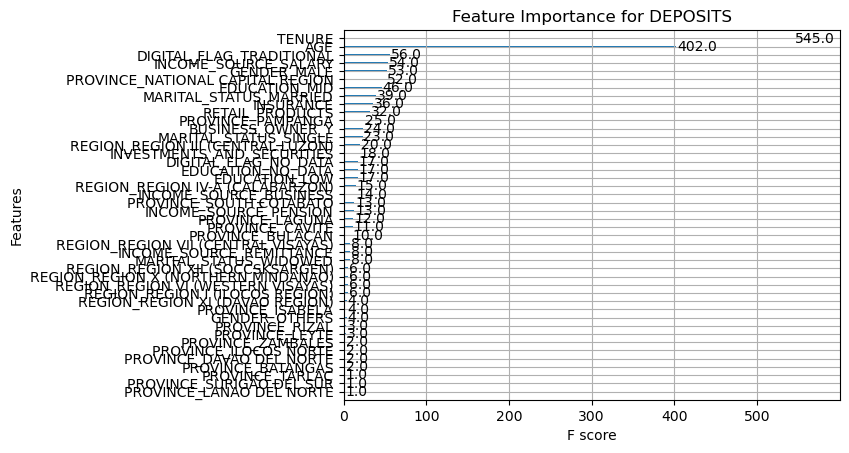

ROC-AUC Score for RETAIL_PRODUCTS: 0.7566208922151245
Classification Report for RETAIL_PRODUCTS:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     14307
           1       0.55      0.27      0.37      5242

    accuracy                           0.75     19549
   macro avg       0.66      0.60      0.60     19549
weighted avg       0.72      0.75      0.71     19549



<Figure size 1500x1000 with 0 Axes>

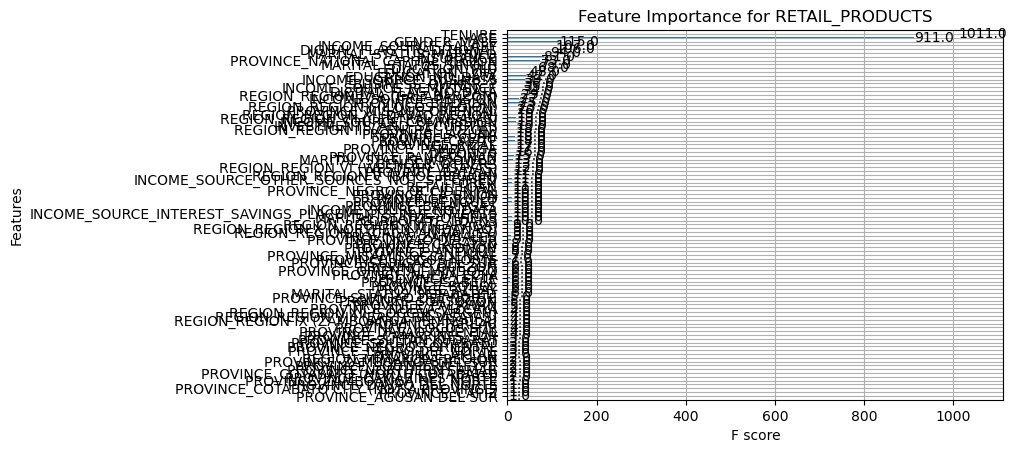

ROC-AUC Score for INVESTMENTS_AND_SECURITIES: 0.6620285720970265
Classification Report for INVESTMENTS_AND_SECURITIES:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19256
           1       0.00      0.00      0.00       293

    accuracy                           0.98     19549
   macro avg       0.49      0.50      0.50     19549
weighted avg       0.97      0.98      0.98     19549



<Figure size 1500x1000 with 0 Axes>

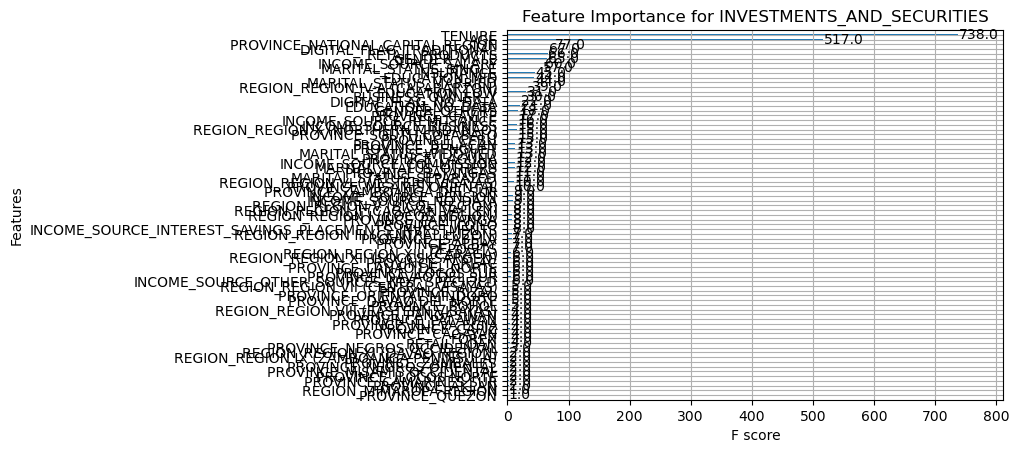

In [17]:
for i in product_categories:
    train_xgboost_propensity_model(
        dataset=merged_df,
        target_product= i,
        test_size=0.3,
        random_state=42,
        use_smote=False
    )

ROC-AUC Score for CORPORATE_LOANS: 0.8876039501039501
Classification Report for CORPORATE_LOANS:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19536
           1       0.50      0.08      0.13        13

    accuracy                           1.00     19549
   macro avg       0.75      0.54      0.57     19549
weighted avg       1.00      1.00      1.00     19549



<Figure size 1500x1000 with 0 Axes>

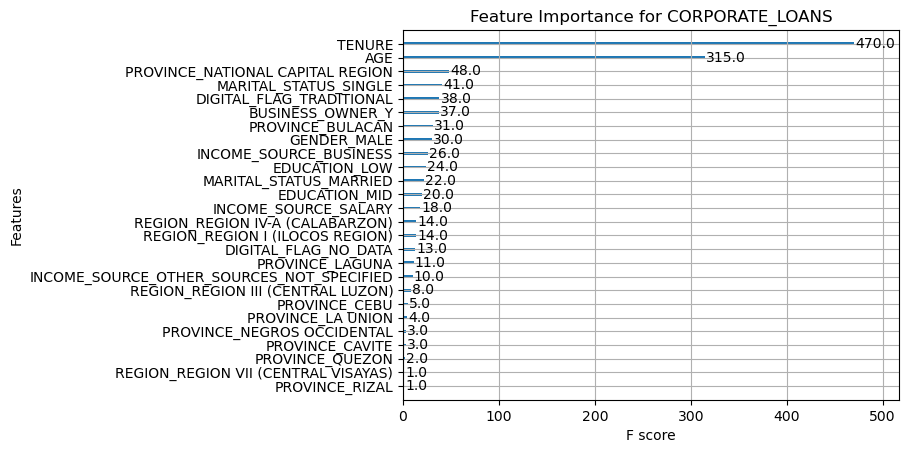

ROC-AUC Score for RETAIL_LOAN: 0.824621858296372
Classification Report for RETAIL_LOAN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19540
           1       0.00      0.00      0.00         9

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



<Figure size 1500x1000 with 0 Axes>

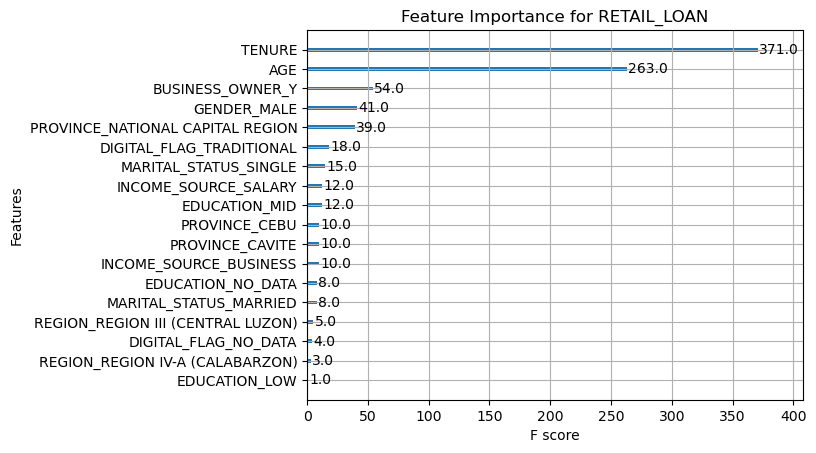

Skipping training for TRADE_SERVICES as it contains a class with fewer than 2 instances.
Skipping training for INVESTMENT_FUNDS as it contains a class with fewer than 2 instances.
Skipping training for SECURITIES as it contains a class with fewer than 2 instances.
ROC-AUC Score for INSURANCE: 0.6408742529587615
Classification Report for INSURANCE:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17663
           1       0.14      0.00      0.00      1886

    accuracy                           0.90     19549
   macro avg       0.52      0.50      0.48     19549
weighted avg       0.83      0.90      0.86     19549



<Figure size 1500x1000 with 0 Axes>

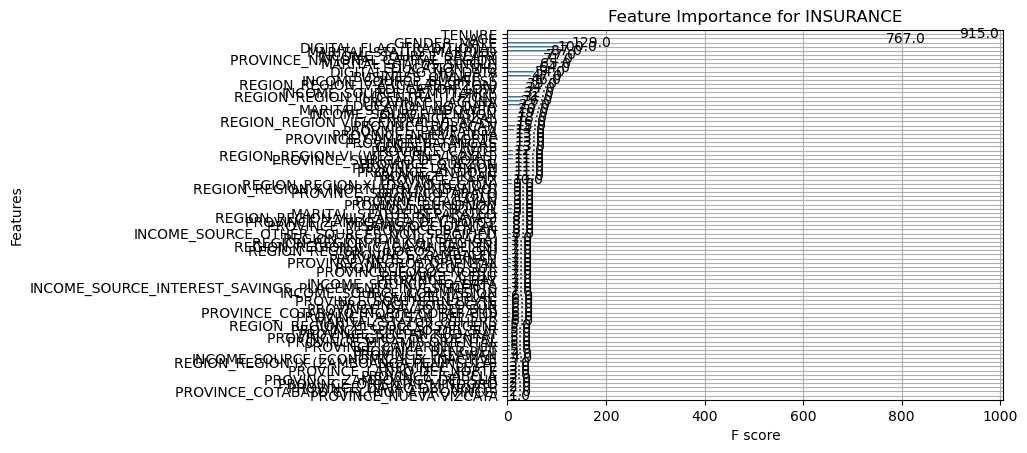

Skipping training for CORPORATE_FINANCE as it contains a class with fewer than 2 instances.
ROC-AUC Score for FOREX: 0.5694572015766521
Classification Report for FOREX:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19403
           1       0.00      0.00      0.00       146

    accuracy                           0.99     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       0.99      0.99      0.99     19549



<Figure size 1500x1000 with 0 Axes>

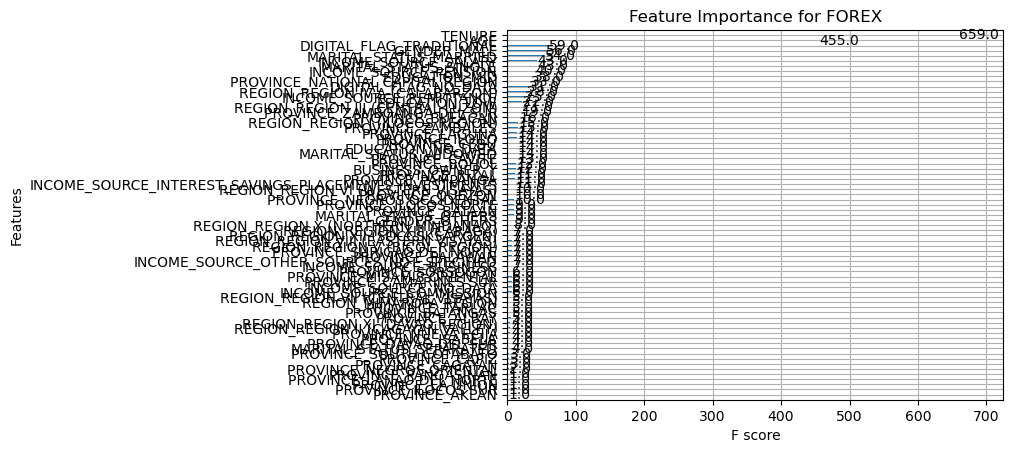

Skipping training for REMITTANCE as it contains a class with fewer than 2 instances.
ROC-AUC Score for CORPORATE_CARDS: 0.2461377122979333
Classification Report for CORPORATE_CARDS:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19548
           1       0.00      0.00      0.00         1

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1500x1000 with 0 Axes>

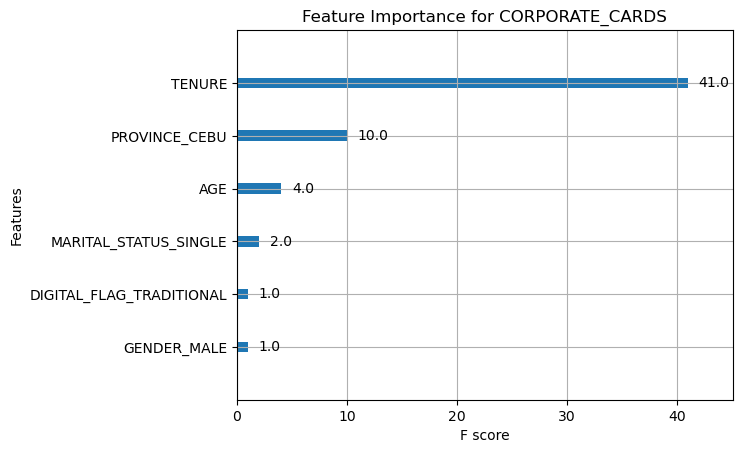

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC-AUC Score for DEPOSITS: 0.6235873255125955
Classification Report for DEPOSITS:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       1.00      1.00      1.00     19518

    accuracy                           1.00     19549
   macro avg       0.50      0.50      0.50     19549
weighted avg       1.00      1.00      1.00     19549



<Figure size 1500x1000 with 0 Axes>

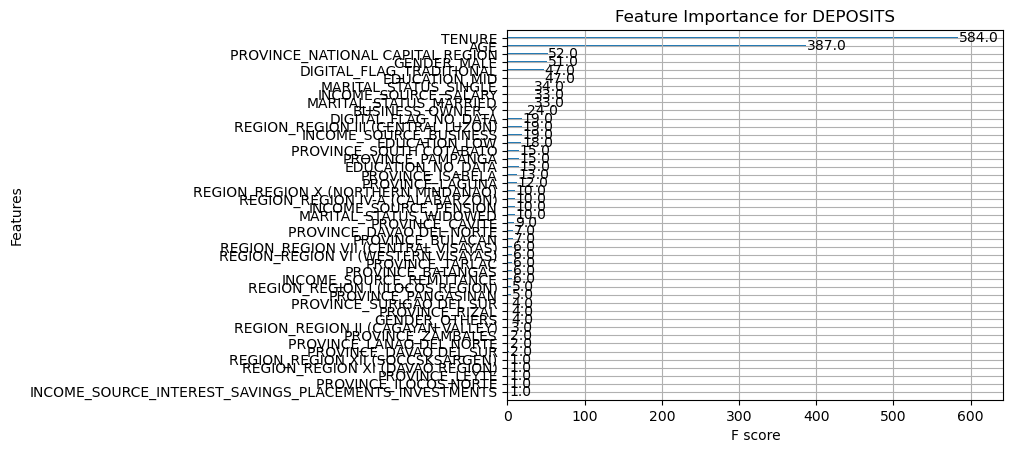

ROC-AUC Score for RETAIL_PRODUCTS: 0.7438236771582719
Classification Report for RETAIL_PRODUCTS:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84     14307
           1       0.52      0.26      0.35      5242

    accuracy                           0.74     19549
   macro avg       0.65      0.59      0.59     19549
weighted avg       0.70      0.74      0.70     19549



<Figure size 1500x1000 with 0 Axes>

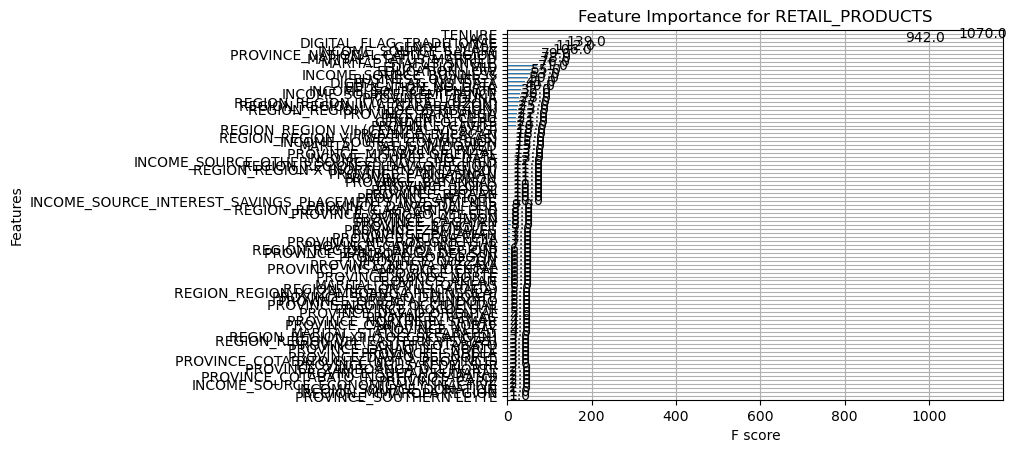

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminang/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC-AUC Score for INVESTMENTS_AND_SECURITIES: 0.6553844836802784
Classification Report for INVESTMENTS_AND_SECURITIES:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19256
           1       0.00      0.00      0.00       293

    accuracy                           0.99     19549
   macro avg       0.49      0.50      0.50     19549
weighted avg       0.97      0.99      0.98     19549



<Figure size 1500x1000 with 0 Axes>

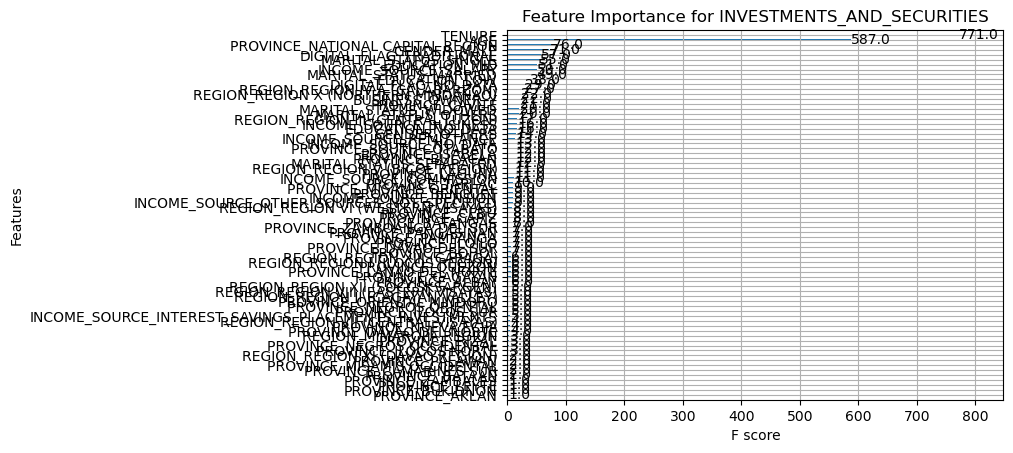

In [18]:
for i in product_categories:
    columns_to_drop = [col for col in product_categories if col != i]
    train_xgboost_propensity_model(
        dataset=merged_df.drop(columns=columns_to_drop),
        target_product=i,
        test_size=0.3,
        random_state=42,
        use_smote=False
    )


## Hyperparameter Tuning

In [19]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'scale_pos_weight': [1, len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up the XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit the model with the best hyperparameters
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(classification_report_output)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'scale_pos_weight': 1, 'subsample': 0.8}
ROC-AUC Score: 0.6037148068927328
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     17663
           1       0.15      0.19      0.17      1886

    accuracy                           0.81     19549
   macro avg       0.53      0.54      0.53     19549
weighted avg       0.84      0.81      0.83     19549

